In [ ]:
### Neural ODE
## A neural ODE is an ODE where a neural network defines its derivative function.


In [65]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
    OptimizationOptimisers, Random, Plots
#c reates a default random number generator (RNG) using the default algorithm provided by the Random module
rng = Random.default_rng()

u0 = Float32[2.0; 0.0]
datasize = 30
tspan = (0.0f0, 1.5f0)
tsteps = range(tspan[1], tspan[2]; length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1] #here is the true parameter, what we want to estimate
    du .= ((u .^ 3)'true_A)' #zhuanzhi
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(); saveat = tsteps)) #simulation data



2×30 Matrix{Float32}:
 2.0  1.9465    1.74178  1.23837  0.577125  …  1.40688   1.37022   1.29214
 0.0  0.798831  1.46473  1.80877  1.86465      0.451368  0.728686  0.972085

In [66]:
##define a neural network with a NeuralODE layer.
#define the layer. 
# Lux is a neural network structure.
######## what is the difference between lux and flux?

dudt2 = Lux.Chain(x -> x .^ 3, Lux.Dense(2, 50, tanh), Lux.Dense(50, 2))
# here we used the x -> x.^3 assumption in the model.
p, st = Lux.setup(rng, dudt2)
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)



NeuralODE(
    model = Chain(
        layer_1 = WrappedFunction(#51),
        layer_2 = Dense(2 => 50, tanh_fast),  # 150 parameters
        layer_3 = Dense(50 => 2),       # 102 parameters
    ),
)         # Total: 252 parameters,
          #        plus 0 states, summarysize 128 bytes.

In [67]:
#built loss function
function predict_neuralode(p)
    Array(prob_neuralode(u0, p, st)[1])
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

loss_neuralode (generic function with 1 method)

In [71]:
#define a callback function.

callback = function (p, l, pred; doplot = false) # do not show every step
    println(l)
    # plot current prediction against data
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction")
        display(plot(plt))
    end
    return false
end
# in callback funciton, I want to print the Parameter
pinit = ComponentArray(p)
callback(pinit, loss_neuralode(pinit)...)

146.59889


false

ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[0.10082148 -0.22839653; -0.22737609 0.117353305; … ; -0.23345844 0.2041723; -0.106892005 0.07583042], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.27511564 -0.10337191 … 0.073367245 -0.25601792; 0.33932912 0.11068664 … 0.30281356 0.04119485], bias = Float32[0.0; 0.0;;]))

In [75]:
# Train using the Adam optimizer
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(optprob,
    OptimizationOptimisers.Adam(0.05);
    callback = callback,
    maxiters = 300)
### where I can get to the paramaters?



146.59889
109.67575
108.65689
104.33869
99.872604
96.81202
94.98054
94.149345
93.755
92.85762
91.18298
88.96207
86.24895
83.203
79.846115
75.402954
69.82388
63.68614
56.704456
51.669144
47.482513
42.733246
37.89195
34.300922
32.42398
31.60905
33.590122
32.42364
33.790165
32.968483
31.027246
29.615313
26.91693
24.959782
22.56166
20.239887
18.10541
15.896622
13.325881
11.113192
9.877861
8.184091
7.344779
7.171473
6.4201765
6.166783
6.0228524
5.4777503
4.852549
4.519093
4.3037286
4.1100616
3.9110086
3.8132863
3.9388213
4.088164
4.198156
4.261499
4.1829667
4.042745
3.8844101
3.7258735
3.6189559
3.5125551
3.4452813
3.3482897
3.3131778
3.255901
3.192729
3.1414642
3.057663
2.933172
2.8190732
2.764882
2.7137516
2.6800106
2.6388273
2.6116726
2.6121588
2.5500398
2.5472517
2.6817794
2.572054
2.4099972
2.8961654
2.9670372
2.2887444
3.0829298
2.6570582
2.5259311
2.7477915
2.1108525
2.4792514
1.9880956
2.397768
1.9650385
2.1562426
1.9878398
1.8991932
1.9201847
1.817825
1.8603698
1.7261113
1.7752857


ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[0.10082148 -0.22839653; -0.22737609 0.117353305; … ; -0.23345844 0.2041723; -0.106892005 0.07583042], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.27511564 -0.10337191 … 0.073367245 -0.25601792; 0.33932912 0.11068664 … 0.30281356 0.04119485], bias = Float32[0.0; 0.0;;]))

In [78]:
println(pinit) # can i just call the parameter here? but it is not matrix,and 
# here is parameter in every layer, where is the final result parameters?

(layer_1 = Float32[], layer_2 = (weight = Float32[0.10082148 -0.22839653; -0.22737609 0.117353305; -0.3338344 0.2966727; 0.2493489 0.18758498; 0.30564114 -0.2938698; 0.22947733 -0.24114963; -0.26696667 0.28592026; 0.224267 -0.24182057; -0.31454024 -0.09842435; 0.046342935 -0.21074599; -0.2659881 0.33619693; 0.24333467 0.29252857; -0.32953054 -0.20097344; -0.33502445 -0.015109458; -0.23635575 0.27162355; 0.092824355 -0.104235634; 0.33945996 0.06770631; -0.17118566 -0.26010284; -0.20803152 -0.0039025093; -0.33116466 0.08720007; -0.27721992 0.2275332; -0.06555785 0.1270718; 0.22302108 -0.0007494515; 0.19097614 -0.16030888; 0.32316217 0.038040414; 0.20451389 0.030693458; 0.32730845 -0.024116483; -0.33281785 0.30349767; 0.20523237 -0.052722953; -0.2530142 -0.051886316; 0.04818251 0.0352537; 0.33161348 0.18749541; -0.30251265 -0.17585284; 0.2794492 -0.2893614; 0.26489934 0.09562213; 0.29261896 -0.29986382; 0.09533859 -0.059003636; 0.26158425 -0.17971307; 0.2798889 -0.072626784; 0.08618271 -0

In [79]:
# Retrain using the LBFGS optimizer
optprob2 = remake(optprob; u0 = result_neuralode.u)

result_neuralode2 = Optimization.solve(optprob2,
    Optim.BFGS(; initial_stepnorm = 0.01);
    callback = callback,
    allow_f_increases = false)

0.16351251
0.16236398
0.1615872
0.15945962
0.15570477
0.15148102
0.15147525
0.13977315
0.11065153
0.0915612
0.07107108
0.060032964
0.05492528
0.05408201
0.047799643
0.044026434
0.042560607
0.040090047
0.03781467
0.036966033
0.032496866
0.030145643
0.027164724
0.02393456
0.023905646
0.023882287
0.023693202
0.0233429
0.021133116
0.019425992
0.018302413
0.017765703
0.017529119
0.017059945
0.016027516
0.01591289
0.015651016
0.0155494725
0.014948571
0.014889768
0.014603462
0.013029433
0.013029433
0.012933817
0.01274791
0.011941185
0.011757536
0.011490571
0.011454213
0.011185722
0.011170883
0.011164482
0.011115154
0.011115154
0.011114157
0.011105894
0.011100541
0.010856313
0.010605772
0.010450058
0.010386876
0.010326747
0.010180092
0.0101689575
0.010128165
0.010127315
0.009954285
0.009952834
0.009952834
0.009951966
0.009951003
0.009951003
0.0099508595
0.0099508595
0.0099508595


u: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[-0.19624814 -0.15682727; 0.94527054 -0.9190346; … ; -0.42218426 -0.021248529; 0.37522542 1.2515346], bias = Float32[0.10744803; 0.24989995; … ; -0.52512145; 0.08778636;;]), layer_3 = (weight = Float32[0.19671388 0.6505215 … 0.5479302 0.17530315; -0.5032248 -0.016539378 … -0.07955281 -0.24022688], bias = Float32[-0.42819843; 0.31935155;;]))

0.0099508595


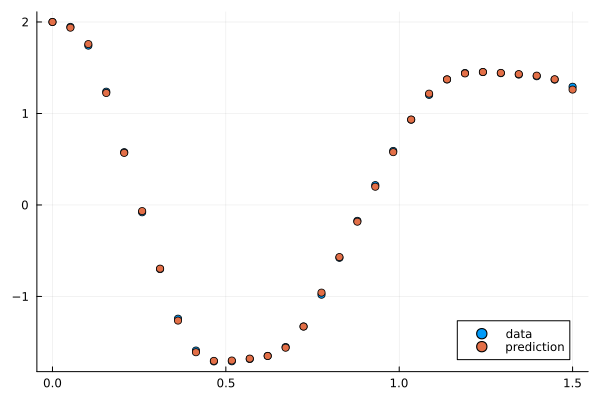

LoadError: UndefVarError: `plt` not defined

In [80]:
callback(result_neuralode2.u, loss_neuralode(result_neuralode2.u)...; doplot = true)
scatter!(plt, tsteps, loss_neuralode(result_neuralode2.u)[2][1, :]; label = "prediction") # hide

#here is the comparison between model and raw data

In [63]:
result_neuralode

u: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[0.1779457 -0.050899975; -0.3544218 -0.26601478; … ; 0.32054693 0.6968284; 0.28021345 0.20360573], bias = Float32[0.49377733; -0.69431394; … ; 0.33887297; -0.04874274;;]), layer_3 = (weight = Float32[-0.31890586 0.56193966 … 0.07358982 -0.5027544; 0.849631 0.17891996 … -0.112636454 0.12030882], bias = Float32[-0.49689323; -0.060129363;;]))

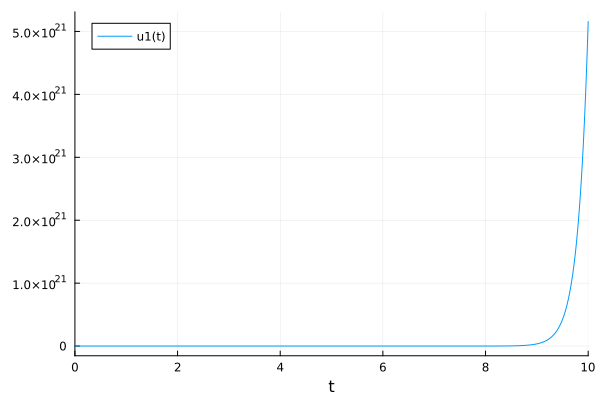

In [102]:
using DifferentialEquations
using DiffEqFlux
using Plots
using GalacticOptim

u0 = [1.0]
tspan = (0.0, 10.0)
tsteps = 0.0:0.1:10.0


function trueODE(du, u, p, t)
    p = 5.0 #here is the true parameter, what we want to estimate
    du[1] = 5.0 * u[1] #zhuanzhi
end


# test the diff eq
prob = ODEProblem(trueODE, u0, tspan)
sol = solve(prob, Tsit5(), alg_hints=[:stiff])
plot(sol)

## analytical solution:x(t)=A⋅e^5t 


In [103]:
# set Neural ode
ode_data = Array(solve(prob, Tsit5(), saveat = tsteps))

u0 = [-1.0]
dudt2 = Lux.Chain(x -> x, 
    Lux.Dense(2, 50, tanh), 
    Lux.Dense(50, 2))

prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(), saveat = tsteps)



NeuralODE(
    model = Chain(
        layer_1 = WrappedFunction(#80),
        layer_2 = Dense(2 => 50, tanh_fast),  # 150 parameters
        layer_3 = Dense(50 => 2),       # 102 parameters
    ),
)         # Total: 252 parameters,
          #        plus 0 states, summarysize 168 bytes.

In [108]:
function predict_neuralode(p)
  Array(prob_neuralode(u0, p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred) # Just sum of squared error
    return loss, pred
end

callback = function (p, l, pred; doplot = true)
  display(l)
  return false
end
loss_neuralode(prob_neuralode.p)

result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, prob_neuralode.p, cb = callback)

#MethodError: objects of type Nothing are not callable?? need to figure out 

LoadError: MethodError: objects of type Nothing are not callable